In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
project_name = 'face'

In [3]:
!pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [8]:
!pip install opendatasets --upgrade

In [17]:
import os

print(os.getcwd())


/content


In [20]:
os.chdir('/content/drive/MyDrive/GAN')
print(os.getcwd())

/content/drive/MyDrive/GAN


In [21]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/jessicali9530/dataset'
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset


100%|██████████| 1.33G/1.33G [00:34<00:00, 40.8MB/s]


KeyboardInterrupt: 

In [24]:
import os

data_dir='/content/drive/MyDrive/GAN/dataset'
print(os.listdir(data_dir))

['celeba-dataset.zip', 'img_align_celeba']


In [26]:
import os
import random

# Path to the folder containing images
folder_path = '/content/drive/MyDrive/GAN/dataset/img_align_celeba/img_align_celeba'

# Get a list of all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.bmp', '.gif'))]

# Check if there are more than 100 images
if len(image_files) > 1000:
    # Randomly select 100 images to keep
    images_to_keep = random.sample(image_files, 1000)

    # Delete the rest of the images
    for image in image_files:
        if image not in images_to_keep:
            os.remove(os.path.join(folder_path, image))
    print(f"Deleted")
else:
    print("Folder contains 100 or fewer images. No images were deleted.")

Deleted


In [28]:
print(os.listdir(data_dir+'/img_align_celeba/img_align_celeba')[:10])

['000077.jpg', '000111.jpg', '000119.jpg', '000170.jpg', '000171.jpg', '000173.jpg', '000223.jpg', '000268.jpg', '000372.jpg', '000378.jpg']


In [29]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [30]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [31]:
train_ds = ImageFolder(data_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [32]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


In [34]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

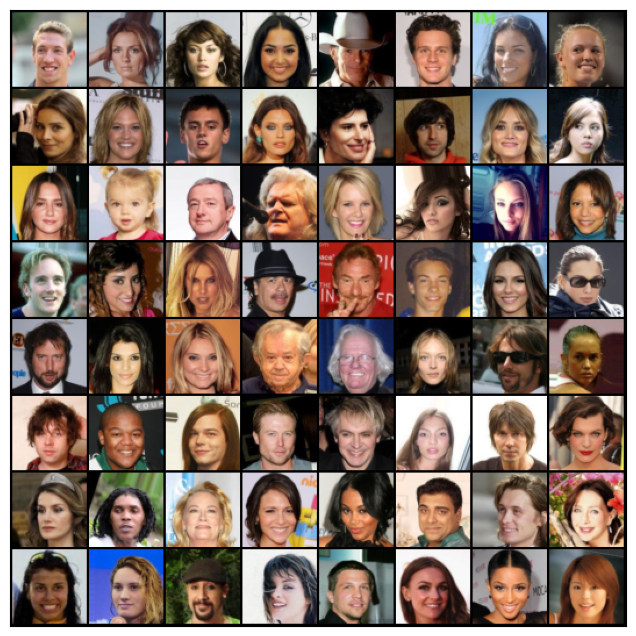

In [35]:
show_batch(train_dl)

In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [37]:
device = get_default_device()
device

device(type='cuda')

In [38]:
train_dl = DeviceDataLoader(train_dl, device)

In [39]:
import torch.nn as nn

In [40]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [41]:
discriminator = to_device(discriminator, device)

In [42]:
latent_size = 128

In [43]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


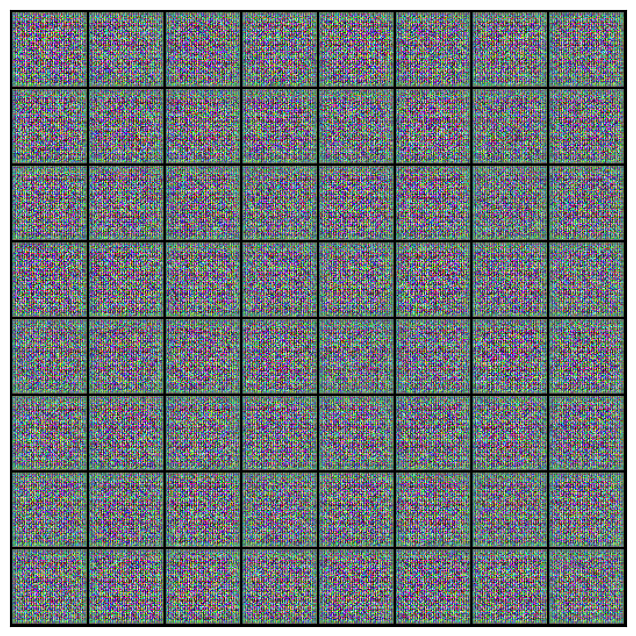

In [44]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


In [45]:
generator = to_device(generator, device)

In [46]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [47]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [48]:
from torchvision.utils import save_image

In [49]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [50]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [51]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


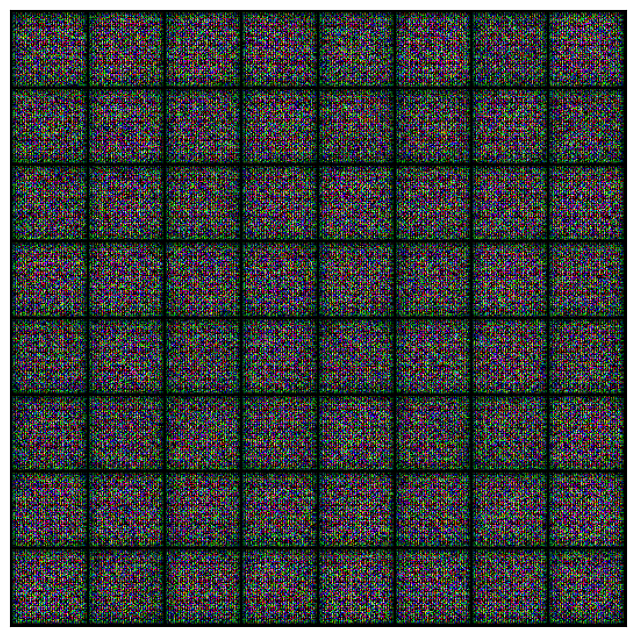

In [52]:
save_samples(0, fixed_latent)

In [53]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [54]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [56]:
lr = 0.0002
epochs = 200

In [57]:
history = fit(epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 5.8293, loss_d: 0.3170, real_score: 0.8741, fake_score: 0.1119
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 11.3306, loss_d: 0.4169, real_score: 0.9412, fake_score: 0.2727
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 15.3144, loss_d: 0.1615, real_score: 0.8744, fake_score: 0.0000
Saving generated-images-0003.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 9.5839, loss_d: 0.0833, real_score: 0.9342, fake_score: 0.0001
Saving generated-images-0004.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 11.6623, loss_d: 0.6656, real_score: 0.9411, fake_score: 0.4146
Saving generated-images-0005.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 16.1271, loss_d: 0.4282, real_score: 0.7513, fake_score: 0.0000
Saving generated-images-0006.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 11.1482, loss_d: 0.1129, real_score: 0.9089, fake_score: 0.0006
Saving generated-images-0007.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 6.9519, loss_d: 0.0232, real_score: 0.9802, fake_score: 0.0014
Saving generated-images-0008.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 17.2174, loss_d: 0.7820, real_score: 0.5977, fake_score: 0.0000
Saving generated-images-0009.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 11.7222, loss_d: 0.3038, real_score: 0.9862, fake_score: 0.2386
Saving generated-images-0010.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 7.7832, loss_d: 0.0284, real_score: 0.9744, fake_score: 0.0011
Saving generated-images-0011.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 6.1016, loss_d: 0.1501, real_score: 0.9891, fake_score: 0.1239
Saving generated-images-0012.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 11.2457, loss_d: 0.3026, real_score: 0.9866, fake_score: 0.2391
Saving generated-images-0013.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 5.4562, loss_d: 0.0448, real_score: 0.9710, fake_score: 0.0136
Saving generated-images-0014.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 6.2488, loss_d: 0.0637, real_score: 0.9810, fake_score: 0.0427
Saving generated-images-0015.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 6.3023, loss_d: 0.0966, real_score: 0.9452, fake_score: 0.0244
Saving generated-images-0016.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 5.7971, loss_d: 0.0797, real_score: 0.9504, fake_score: 0.0253
Saving generated-images-0017.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 5.7924, loss_d: 0.0877, real_score: 0.9429, fake_score: 0.0219
Saving generated-images-0018.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 5.6865, loss_d: 0.0544, real_score: 0.9592, fake_score: 0.0104
Saving generated-images-0019.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 7.4969, loss_d: 7.0046, real_score: 0.0244, fake_score: 0.0000
Saving generated-images-0020.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 6.1683, loss_d: 0.4611, real_score: 0.8274, fake_score: 0.1840
Saving generated-images-0021.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 7.9963, loss_d: 0.6702, real_score: 0.6406, fake_score: 0.0021
Saving generated-images-0022.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 5.9840, loss_d: 0.2934, real_score: 0.9866, fake_score: 0.2343
Saving generated-images-0023.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 2.1526, loss_d: 1.2815, real_score: 0.9500, fake_score: 0.5215
Saving generated-images-0024.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 3.8232, loss_d: 0.2861, real_score: 0.8435, fake_score: 0.0941
Saving generated-images-0025.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 5.7521, loss_d: 0.3633, real_score: 0.9679, fake_score: 0.2674
Saving generated-images-0026.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 2.7146, loss_d: 0.2364, real_score: 0.8567, fake_score: 0.0628
Saving generated-images-0027.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 4.4378, loss_d: 0.1478, real_score: 0.9553, fake_score: 0.0924
Saving generated-images-0028.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 3.2466, loss_d: 0.3854, real_score: 0.7618, fake_score: 0.0715
Saving generated-images-0029.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 3.9328, loss_d: 0.9801, real_score: 0.4648, fake_score: 0.0046
Saving generated-images-0030.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 3.2443, loss_d: 0.1927, real_score: 0.8657, fake_score: 0.0306
Saving generated-images-0031.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 4.0839, loss_d: 0.3944, real_score: 0.7432, fake_score: 0.0504
Saving generated-images-0032.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 4.5693, loss_d: 0.3192, real_score: 0.8960, fake_score: 0.1581
Saving generated-images-0033.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 3.7468, loss_d: 0.2229, real_score: 0.8824, fake_score: 0.0748
Saving generated-images-0034.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 2.8213, loss_d: 0.2401, real_score: 0.8269, fake_score: 0.0259
Saving generated-images-0035.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 3.2570, loss_d: 0.4058, real_score: 0.8306, fake_score: 0.1701
Saving generated-images-0036.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 2.1893, loss_d: 3.0125, real_score: 0.1239, fake_score: 0.0024
Saving generated-images-0037.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 1.5218, loss_d: 0.7394, real_score: 0.6100, fake_score: 0.0401
Saving generated-images-0038.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 3.0214, loss_d: 0.5542, real_score: 0.8298, fake_score: 0.2784
Saving generated-images-0039.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 0.9921, loss_d: 0.9615, real_score: 0.4915, fake_score: 0.0608
Saving generated-images-0040.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 2.3453, loss_d: 0.6639, real_score: 0.7054, fake_score: 0.2263
Saving generated-images-0041.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 3.2339, loss_d: 0.4954, real_score: 0.8683, fake_score: 0.2759
Saving generated-images-0042.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 3.1330, loss_d: 0.3896, real_score: 0.7975, fake_score: 0.1245
Saving generated-images-0043.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 3.2973, loss_d: 0.3520, real_score: 0.7899, fake_score: 0.0815
Saving generated-images-0044.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 6.4936, loss_d: 0.9976, real_score: 0.9636, fake_score: 0.5689
Saving generated-images-0045.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 4.1034, loss_d: 0.2686, real_score: 0.8614, fake_score: 0.0919
Saving generated-images-0046.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 6.7854, loss_d: 0.5025, real_score: 0.9627, fake_score: 0.3362
Saving generated-images-0047.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 2.6724, loss_d: 0.5243, real_score: 0.7224, fake_score: 0.1411
Saving generated-images-0048.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 4.6311, loss_d: 0.5660, real_score: 0.8863, fake_score: 0.3233
Saving generated-images-0049.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 4.4963, loss_d: 0.3005, real_score: 0.9037, fake_score: 0.1671
Saving generated-images-0050.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 4.7899, loss_d: 0.7072, real_score: 0.8718, fake_score: 0.3851
Saving generated-images-0051.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 1.9909, loss_d: 0.7397, real_score: 0.5788, fake_score: 0.1051
Saving generated-images-0052.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 3.4297, loss_d: 0.4247, real_score: 0.8277, fake_score: 0.1887
Saving generated-images-0053.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 3.1259, loss_d: 0.4148, real_score: 0.8315, fake_score: 0.1793
Saving generated-images-0054.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 4.5775, loss_d: 0.2465, real_score: 0.9281, fake_score: 0.1465
Saving generated-images-0055.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 3.5762, loss_d: 0.9078, real_score: 0.9780, fake_score: 0.5058
Saving generated-images-0056.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 4.5515, loss_d: 0.8623, real_score: 0.8475, fake_score: 0.4470
Saving generated-images-0057.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 4.0339, loss_d: 0.4135, real_score: 0.8587, fake_score: 0.2029
Saving generated-images-0058.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 5.8977, loss_d: 0.5293, real_score: 0.9606, fake_score: 0.3626
Saving generated-images-0059.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 2.4835, loss_d: 0.4984, real_score: 0.7192, fake_score: 0.0730
Saving generated-images-0060.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 6.9646, loss_d: 0.9631, real_score: 0.9483, fake_score: 0.5431
Saving generated-images-0061.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 5.6931, loss_d: 0.5981, real_score: 0.8542, fake_score: 0.3237
Saving generated-images-0062.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 4.8693, loss_d: 0.2840, real_score: 0.8715, fake_score: 0.1183
Saving generated-images-0063.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 3.1161, loss_d: 0.4518, real_score: 0.7060, fake_score: 0.0561
Saving generated-images-0064.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 3.4009, loss_d: 1.8263, real_score: 0.2332, fake_score: 0.0033
Saving generated-images-0065.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 3.7680, loss_d: 0.3108, real_score: 0.8676, fake_score: 0.1349
Saving generated-images-0066.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 6.4026, loss_d: 0.4453, real_score: 0.9354, fake_score: 0.2963
Saving generated-images-0067.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 4.7413, loss_d: 0.6198, real_score: 0.6030, fake_score: 0.0197
Saving generated-images-0068.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 3.0047, loss_d: 0.4205, real_score: 0.7297, fake_score: 0.0536
Saving generated-images-0069.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 4.7651, loss_d: 0.3758, real_score: 0.9187, fake_score: 0.2317
Saving generated-images-0070.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 3.5241, loss_d: 0.2941, real_score: 0.8038, fake_score: 0.0466
Saving generated-images-0071.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 4.0674, loss_d: 0.2211, real_score: 0.8634, fake_score: 0.0554
Saving generated-images-0072.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 4.2667, loss_d: 1.3649, real_score: 0.3184, fake_score: 0.0004
Saving generated-images-0073.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 5.8344, loss_d: 0.4905, real_score: 0.6857, fake_score: 0.0045
Saving generated-images-0074.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 5.9758, loss_d: 0.4483, real_score: 0.9380, fake_score: 0.2849
Saving generated-images-0075.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 3.7137, loss_d: 0.2333, real_score: 0.9319, fake_score: 0.1373
Saving generated-images-0076.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 4.6206, loss_d: 0.2801, real_score: 0.8969, fake_score: 0.1440
Saving generated-images-0077.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 4.8514, loss_d: 0.4099, real_score: 0.8980, fake_score: 0.2365
Saving generated-images-0078.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 4.2107, loss_d: 0.3626, real_score: 0.9769, fake_score: 0.2612
Saving generated-images-0079.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 5.2847, loss_d: 0.8723, real_score: 0.4983, fake_score: 0.0050
Saving generated-images-0080.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 6.6124, loss_d: 0.7719, real_score: 0.9692, fake_score: 0.4942
Saving generated-images-0081.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 4.5085, loss_d: 0.4216, real_score: 0.8963, fake_score: 0.2470
Saving generated-images-0082.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 6.2916, loss_d: 0.7038, real_score: 0.9804, fake_score: 0.4288
Saving generated-images-0083.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 4.0634, loss_d: 0.3547, real_score: 0.9268, fake_score: 0.2199
Saving generated-images-0084.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 4.1648, loss_d: 0.2623, real_score: 0.8483, fake_score: 0.0732
Saving generated-images-0085.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 4.6745, loss_d: 0.2386, real_score: 0.8760, fake_score: 0.0858
Saving generated-images-0086.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 1.3638, loss_d: 0.5670, real_score: 0.6518, fake_score: 0.0571
Saving generated-images-0087.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 3.7498, loss_d: 0.3113, real_score: 0.8825, fake_score: 0.1555
Saving generated-images-0088.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 4.8331, loss_d: 0.2984, real_score: 0.9083, fake_score: 0.1681
Saving generated-images-0089.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 4.6636, loss_d: 0.2787, real_score: 0.8454, fake_score: 0.0861
Saving generated-images-0090.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 4.2433, loss_d: 0.2950, real_score: 0.8957, fake_score: 0.1507
Saving generated-images-0091.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 7.4433, loss_d: 0.5765, real_score: 0.9694, fake_score: 0.3904
Saving generated-images-0092.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 6.2274, loss_d: 0.4527, real_score: 0.9268, fake_score: 0.2772
Saving generated-images-0093.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 5.3737, loss_d: 0.3077, real_score: 0.9472, fake_score: 0.2035
Saving generated-images-0094.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 3.2237, loss_d: 0.2316, real_score: 0.8457, fake_score: 0.0452
Saving generated-images-0095.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 2.0625, loss_d: 0.1897, real_score: 0.8795, fake_score: 0.0360
Saving generated-images-0096.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 2.6482, loss_d: 0.6757, real_score: 0.6655, fake_score: 0.1601
Saving generated-images-0097.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 4.9085, loss_d: 0.5507, real_score: 0.9180, fake_score: 0.3378
Saving generated-images-0098.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 3.7421, loss_d: 0.5270, real_score: 0.6813, fake_score: 0.0401
Saving generated-images-0099.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 3.4828, loss_d: 0.4489, real_score: 0.7839, fake_score: 0.1359
Saving generated-images-0100.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 4.4515, loss_d: 1.6225, real_score: 0.3091, fake_score: 0.0008
Saving generated-images-0101.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 9.7097, loss_d: 1.1106, real_score: 0.9919, fake_score: 0.6006
Saving generated-images-0102.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 6.0922, loss_d: 0.7006, real_score: 0.9247, fake_score: 0.4111
Saving generated-images-0103.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 3.5606, loss_d: 0.4303, real_score: 0.7790, fake_score: 0.1098
Saving generated-images-0104.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 5.3340, loss_d: 0.4987, real_score: 0.8885, fake_score: 0.2783
Saving generated-images-0105.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 4.0604, loss_d: 1.0492, real_score: 0.4625, fake_score: 0.0058
Saving generated-images-0106.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 3.4684, loss_d: 0.2911, real_score: 0.8266, fake_score: 0.0602
Saving generated-images-0107.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 5.2159, loss_d: 0.5665, real_score: 0.9748, fake_score: 0.3790
Saving generated-images-0108.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 3.9986, loss_d: 0.2477, real_score: 0.8840, fake_score: 0.1025
Saving generated-images-0109.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 4.2883, loss_d: 0.2773, real_score: 0.9644, fake_score: 0.1840
Saving generated-images-0110.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 2.8034, loss_d: 0.4610, real_score: 0.6927, fake_score: 0.0334
Saving generated-images-0111.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 6.1205, loss_d: 0.4216, real_score: 0.9040, fake_score: 0.2447
Saving generated-images-0112.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 1.7972, loss_d: 0.5930, real_score: 0.6249, fake_score: 0.0390
Saving generated-images-0113.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 4.1663, loss_d: 0.3935, real_score: 0.7844, fake_score: 0.0829
Saving generated-images-0114.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 4.4694, loss_d: 0.4817, real_score: 0.9278, fake_score: 0.2982
Saving generated-images-0115.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 5.5839, loss_d: 0.4399, real_score: 0.9401, fake_score: 0.2833
Saving generated-images-0116.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 3.2858, loss_d: 0.7441, real_score: 0.5639, fake_score: 0.0323
Saving generated-images-0117.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 4.1591, loss_d: 0.3048, real_score: 0.8639, fake_score: 0.1314
Saving generated-images-0118.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 4.0155, loss_d: 0.3720, real_score: 0.8594, fake_score: 0.1717
Saving generated-images-0119.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 3.8437, loss_d: 0.2869, real_score: 0.7943, fake_score: 0.0296
Saving generated-images-0120.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 2.2667, loss_d: 0.3655, real_score: 0.7912, fake_score: 0.0909
Saving generated-images-0121.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 4.9247, loss_d: 0.5906, real_score: 0.9654, fake_score: 0.3871
Saving generated-images-0122.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 4.3937, loss_d: 0.3432, real_score: 0.8849, fake_score: 0.1672
Saving generated-images-0123.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 5.4119, loss_d: 0.4286, real_score: 0.8964, fake_score: 0.2185
Saving generated-images-0124.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 3.7162, loss_d: 0.4318, real_score: 0.7190, fake_score: 0.0521
Saving generated-images-0125.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 3.8084, loss_d: 0.3549, real_score: 0.8484, fake_score: 0.1561
Saving generated-images-0126.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 4.3793, loss_d: 0.2853, real_score: 0.8863, fake_score: 0.1366
Saving generated-images-0127.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 2.6506, loss_d: 0.3201, real_score: 0.8017, fake_score: 0.0740
Saving generated-images-0128.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 3.2851, loss_d: 0.2712, real_score: 0.8590, fake_score: 0.0930
Saving generated-images-0129.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 6.2097, loss_d: 0.4244, real_score: 0.9644, fake_score: 0.2974
Saving generated-images-0130.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 1.5266, loss_d: 0.9861, real_score: 0.4692, fake_score: 0.0280
Saving generated-images-0131.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 4.6633, loss_d: 0.5158, real_score: 0.8824, fake_score: 0.2820
Saving generated-images-0132.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 5.6395, loss_d: 0.8185, real_score: 0.9803, fake_score: 0.4873
Saving generated-images-0133.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 5.5094, loss_d: 0.5128, real_score: 0.9351, fake_score: 0.3253
Saving generated-images-0134.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 2.9037, loss_d: 0.7684, real_score: 0.5170, fake_score: 0.0081
Saving generated-images-0135.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 4.2959, loss_d: 0.2231, real_score: 0.9347, fake_score: 0.1358
Saving generated-images-0136.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 7.4475, loss_d: 0.5747, real_score: 0.9583, fake_score: 0.3840
Saving generated-images-0137.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 1.4140, loss_d: 1.6562, real_score: 0.2573, fake_score: 0.0032
Saving generated-images-0138.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 2.0687, loss_d: 0.5436, real_score: 0.6698, fake_score: 0.0711
Saving generated-images-0139.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 5.1335, loss_d: 0.6122, real_score: 0.8968, fake_score: 0.3604
Saving generated-images-0140.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 3.4992, loss_d: 1.5959, real_score: 0.2834, fake_score: 0.0021
Saving generated-images-0141.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 4.3778, loss_d: 0.5058, real_score: 0.6612, fake_score: 0.0105
Saving generated-images-0142.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 4.0138, loss_d: 0.3068, real_score: 0.8885, fake_score: 0.1538
Saving generated-images-0143.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 4.6035, loss_d: 0.3433, real_score: 0.9084, fake_score: 0.2046
Saving generated-images-0144.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 3.4836, loss_d: 0.2321, real_score: 0.8298, fake_score: 0.0298
Saving generated-images-0145.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 4.2891, loss_d: 0.2725, real_score: 0.9606, fake_score: 0.1770
Saving generated-images-0146.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 6.4876, loss_d: 0.8289, real_score: 0.9821, fake_score: 0.5015
Saving generated-images-0147.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 4.2722, loss_d: 0.3009, real_score: 0.8012, fake_score: 0.0455
Saving generated-images-0148.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 3.6682, loss_d: 0.3125, real_score: 0.8447, fake_score: 0.1113
Saving generated-images-0149.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 5.2455, loss_d: 0.1096, real_score: 0.9545, fake_score: 0.0585
Saving generated-images-0150.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 4.0230, loss_d: 0.1918, real_score: 0.9529, fake_score: 0.1260
Saving generated-images-0151.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 4.7441, loss_d: 0.1418, real_score: 0.9398, fake_score: 0.0731
Saving generated-images-0152.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 4.5178, loss_d: 0.1237, real_score: 0.9505, fake_score: 0.0665
Saving generated-images-0153.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 3.9087, loss_d: 0.6566, real_score: 0.8730, fake_score: 0.3309
Saving generated-images-0154.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 5.1451, loss_d: 0.5462, real_score: 0.8816, fake_score: 0.2999
Saving generated-images-0155.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 3.4903, loss_d: 0.3871, real_score: 0.7899, fake_score: 0.1038
Saving generated-images-0156.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 4.7326, loss_d: 0.3797, real_score: 0.9593, fake_score: 0.2592
Saving generated-images-0157.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 3.3614, loss_d: 0.2521, real_score: 0.9160, fake_score: 0.1392
Saving generated-images-0158.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 2.8216, loss_d: 0.2875, real_score: 0.8237, fake_score: 0.0744
Saving generated-images-0159.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 4.0202, loss_d: 0.9971, real_score: 0.4705, fake_score: 0.0023
Saving generated-images-0160.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 6.4540, loss_d: 0.7545, real_score: 0.9527, fake_score: 0.4471
Saving generated-images-0161.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 2.3459, loss_d: 0.5314, real_score: 0.6809, fake_score: 0.0948
Saving generated-images-0162.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 4.4464, loss_d: 0.2390, real_score: 0.9413, fake_score: 0.1513
Saving generated-images-0163.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 8.6635, loss_d: 1.2287, real_score: 0.9875, fake_score: 0.6541
Saving generated-images-0164.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 5.1482, loss_d: 0.5272, real_score: 0.9638, fake_score: 0.3551
Saving generated-images-0165.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 3.0471, loss_d: 0.2791, real_score: 0.8882, fake_score: 0.1372
Saving generated-images-0166.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 4.1153, loss_d: 0.2864, real_score: 0.9149, fake_score: 0.1650
Saving generated-images-0167.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 3.2990, loss_d: 0.1873, real_score: 0.8975, fake_score: 0.0668
Saving generated-images-0168.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 4.2143, loss_d: 0.2400, real_score: 0.9181, fake_score: 0.1349
Saving generated-images-0169.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 3.5610, loss_d: 0.1084, real_score: 0.9362, fake_score: 0.0386
Saving generated-images-0170.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 3.3579, loss_d: 0.1664, real_score: 0.8917, fake_score: 0.0445
Saving generated-images-0171.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 4.0284, loss_d: 0.1484, real_score: 0.9667, fake_score: 0.1011
Saving generated-images-0172.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 5.6035, loss_d: 0.2285, real_score: 0.9770, fake_score: 0.1668
Saving generated-images-0173.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 4.8410, loss_d: 0.8364, real_score: 0.8989, fake_score: 0.4400
Saving generated-images-0174.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 5.9568, loss_d: 0.6861, real_score: 0.9076, fake_score: 0.3875
Saving generated-images-0175.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 2.9485, loss_d: 0.4802, real_score: 0.6897, fake_score: 0.0661
Saving generated-images-0176.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 4.5892, loss_d: 0.3952, real_score: 0.9205, fake_score: 0.2418
Saving generated-images-0177.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 6.9230, loss_d: 0.8318, real_score: 0.9769, fake_score: 0.5016
Saving generated-images-0178.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 4.3362, loss_d: 0.1806, real_score: 0.9249, fake_score: 0.0900
Saving generated-images-0179.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 3.3467, loss_d: 0.5608, real_score: 0.6182, fake_score: 0.0075
Saving generated-images-0180.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 3.6564, loss_d: 0.2638, real_score: 0.8939, fake_score: 0.1304
Saving generated-images-0181.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 4.6453, loss_d: 0.2528, real_score: 0.9366, fake_score: 0.1567
Saving generated-images-0182.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 2.7734, loss_d: 0.3909, real_score: 0.7080, fake_score: 0.0157
Saving generated-images-0183.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 2.5916, loss_d: 0.2483, real_score: 0.8591, fake_score: 0.0823
Saving generated-images-0184.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 3.8821, loss_d: 0.5282, real_score: 0.8552, fake_score: 0.2592
Saving generated-images-0185.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 4.1052, loss_d: 0.2710, real_score: 0.8749, fake_score: 0.1125
Saving generated-images-0186.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 4.5383, loss_d: 0.3069, real_score: 0.9585, fake_score: 0.2173
Saving generated-images-0187.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 4.7731, loss_d: 0.2334, real_score: 0.9488, fake_score: 0.1551
Saving generated-images-0188.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 3.5687, loss_d: 0.2534, real_score: 0.9532, fake_score: 0.1701
Saving generated-images-0189.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 3.3706, loss_d: 0.1441, real_score: 0.9478, fake_score: 0.0826
Saving generated-images-0190.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 4.7274, loss_d: 0.1946, real_score: 0.9619, fake_score: 0.1368
Saving generated-images-0191.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 3.1808, loss_d: 0.1705, real_score: 0.9077, fake_score: 0.0660
Saving generated-images-0192.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 3.6786, loss_d: 0.1348, real_score: 0.9195, fake_score: 0.0468
Saving generated-images-0193.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 3.5891, loss_d: 0.1570, real_score: 0.9370, fake_score: 0.0841
Saving generated-images-0194.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 3.4206, loss_d: 3.2477, real_score: 0.9925, fake_score: 0.9064
Saving generated-images-0195.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 3.1297, loss_d: 0.6935, real_score: 0.7367, fake_score: 0.2679
Saving generated-images-0196.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 3.7730, loss_d: 0.4446, real_score: 0.7560, fake_score: 0.1199
Saving generated-images-0197.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 3.7696, loss_d: 0.3519, real_score: 0.7985, fake_score: 0.0970
Saving generated-images-0198.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 4.8905, loss_d: 0.4052, real_score: 0.9274, fake_score: 0.2554
Saving generated-images-0199.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 3.3874, loss_d: 0.3120, real_score: 0.7765, fake_score: 0.0387
Saving generated-images-0200.png


In [58]:
losses_g, losses_d, real_scores, fake_scores = history

In [59]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
generator.load_state_dict(torch.load('G.pth'))
discriminator.load_state_dict(torch.load('D.pth'))

<ipython-input-52-c5bc4581663f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('G.pth'))
<ipython-input-52-c5bc4581663f>:2: FutureWarn

<All keys matched successfully>

In [ ]:
generator.train()
discriminator.train()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [ ]:
start_epoch = 101  # Resuming from epoch 100
num_epochs = 200

In [ ]:
import torch
from tqdm import tqdm

# Function to train the GAN
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Load the previously saved generator and discriminator state_dicts
    generator.load_state_dict(torch.load('G.pth'))
    discriminator.load_state_dict(torch.load('D.pth'))

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers (you can also load optimizer state_dicts if saved)
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # You can load optimizer states if you saved them earlier
    # opt_g.load_state_dict(torch.load('optimizer_G.pth'))
    # opt_d.load_state_dict(torch.load('optimizer_D.pth'))

    # Start training from the specified epoch (e.g., 101 for resuming)
    for epoch in range(start_idx, epochs + start_idx):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (for the last batch of the current epoch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch, epochs + start_idx - 1, loss_g, loss_d, real_score, fake_score))

        # Save generated samples from the generator
        save_samples(epoch, fixed_latent, show=False)

        # Optionally, save the model's state every 10 epochs or so
        if epoch % 10 == 0:
            torch.save(generator.state_dict(), 'G.pth')
            torch.save(discriminator.state_dict(), 'D.pth')
            # Optionally save optimizer states
            # torch.save(opt_g.state_dict(), 'optimizer_G.pth')
            # torch.save(opt_d.state_dict(), 'optimizer_D.pth')

    return losses_g, losses_d, real_scores, fake_scores


In [ ]:
losses_g, losses_d, real_scores, fake_scores = fit(100, lr=0.0002, start_idx=101)


<ipython-input-55-0ca2539e51e4>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('G.pth'))
<ipython-input-55-0ca2539e51e4>:10: FutureWar

Epoch [101/200], loss_g: 5.9027, loss_d: 0.5534, real_score: 0.7843, fake_score: 0.1369
Saving generated-images-0101.png


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Epoch [102/200], loss_g: 5.1614, loss_d: 0.9521, real_score: 0.6001, fake_score: 0.1183
Saving generated-images-0102.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [103/200], loss_g: 4.7514, loss_d: 0.4067, real_score: 0.8411, fake_score: 0.1751
Saving generated-images-0103.png


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch [104/200], loss_g: 5.5715, loss_d: 0.5627, real_score: 0.6619, fake_score: 0.0224
Saving generated-images-0104.png


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch [105/200], loss_g: 3.7079, loss_d: 0.4456, real_score: 0.8311, fake_score: 0.1772
Saving generated-images-0105.png


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch [106/200], loss_g: 2.2136, loss_d: 0.2824, real_score: 0.8530, fake_score: 0.0760
Saving generated-images-0106.png


100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch [107/200], loss_g: 3.5909, loss_d: 0.9452, real_score: 0.4731, fake_score: 0.0169
Saving generated-images-0107.png


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Epoch [108/200], loss_g: 4.8964, loss_d: 0.5919, real_score: 0.8417, fake_score: 0.2944
Saving generated-images-0108.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [109/200], loss_g: 5.1339, loss_d: 0.3222, real_score: 0.8058, fake_score: 0.0499
Saving generated-images-0109.png


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch [110/200], loss_g: 3.0524, loss_d: 1.3885, real_score: 0.3292, fake_score: 0.0240
Saving generated-images-0110.png


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


Epoch [111/200], loss_g: 3.4033, loss_d: 0.6074, real_score: 0.7480, fake_score: 0.2180
Saving generated-images-0111.png


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch [112/200], loss_g: 5.5802, loss_d: 1.6127, real_score: 0.8537, fake_score: 0.7072
Saving generated-images-0112.png


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Epoch [113/200], loss_g: 4.0427, loss_d: 0.6686, real_score: 0.6803, fake_score: 0.1855
Saving generated-images-0113.png


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Epoch [114/200], loss_g: 2.7680, loss_d: 1.6254, real_score: 0.3022, fake_score: 0.0288
Saving generated-images-0114.png


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch [115/200], loss_g: 5.2083, loss_d: 0.8287, real_score: 0.8179, fake_score: 0.4286
Saving generated-images-0115.png


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch [116/200], loss_g: 2.2049, loss_d: 1.0763, real_score: 0.4570, fake_score: 0.0885
Saving generated-images-0116.png


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


Epoch [117/200], loss_g: 5.4645, loss_d: 1.1675, real_score: 0.8149, fake_score: 0.5673
Saving generated-images-0117.png


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


Epoch [118/200], loss_g: 3.4279, loss_d: 0.7141, real_score: 0.8514, fake_score: 0.3939
Saving generated-images-0118.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [119/200], loss_g: 3.2963, loss_d: 0.5198, real_score: 0.8640, fake_score: 0.2834
Saving generated-images-0119.png


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Epoch [120/200], loss_g: 3.9794, loss_d: 0.4751, real_score: 0.7526, fake_score: 0.1328
Saving generated-images-0120.png


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch [121/200], loss_g: 4.6043, loss_d: 0.3234, real_score: 0.8524, fake_score: 0.1322
Saving generated-images-0121.png


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch [122/200], loss_g: 1.7963, loss_d: 2.3057, real_score: 0.1603, fake_score: 0.0052
Saving generated-images-0122.png


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Epoch [123/200], loss_g: 3.4940, loss_d: 0.4657, real_score: 0.7353, fake_score: 0.0798
Saving generated-images-0123.png


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch [124/200], loss_g: 3.5495, loss_d: 0.5700, real_score: 0.9271, fake_score: 0.3409
Saving generated-images-0124.png


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch [125/200], loss_g: 2.1875, loss_d: 0.7523, real_score: 0.6066, fake_score: 0.0950
Saving generated-images-0125.png


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Epoch [126/200], loss_g: 1.9227, loss_d: 1.2364, real_score: 0.3968, fake_score: 0.0232
Saving generated-images-0126.png


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch [127/200], loss_g: 2.9235, loss_d: 0.3643, real_score: 0.8502, fake_score: 0.1651
Saving generated-images-0127.png


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Epoch [128/200], loss_g: 5.1056, loss_d: 0.7029, real_score: 0.8689, fake_score: 0.3791
Saving generated-images-0128.png


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Epoch [129/200], loss_g: 1.5102, loss_d: 1.0607, real_score: 0.4784, fake_score: 0.0506
Saving generated-images-0129.png


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch [130/200], loss_g: 4.1107, loss_d: 0.4525, real_score: 0.8861, fake_score: 0.2623
Saving generated-images-0130.png


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch [131/200], loss_g: 5.3690, loss_d: 0.8556, real_score: 0.8863, fake_score: 0.4737
Saving generated-images-0131.png


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch [132/200], loss_g: 2.6225, loss_d: 0.2518, real_score: 0.8725, fake_score: 0.0869
Saving generated-images-0132.png


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch [133/200], loss_g: 2.6640, loss_d: 0.9001, real_score: 0.5049, fake_score: 0.0462
Saving generated-images-0133.png


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch [134/200], loss_g: 2.3579, loss_d: 0.8008, real_score: 0.5681, fake_score: 0.0735
Saving generated-images-0134.png


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch [135/200], loss_g: 2.3429, loss_d: 0.7790, real_score: 0.5650, fake_score: 0.0744
Saving generated-images-0135.png


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch [136/200], loss_g: 3.7941, loss_d: 0.7726, real_score: 0.7269, fake_score: 0.2945
Saving generated-images-0136.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [137/200], loss_g: 7.4598, loss_d: 1.1082, real_score: 0.9649, fake_score: 0.6141
Saving generated-images-0137.png


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch [138/200], loss_g: 5.8831, loss_d: 0.6869, real_score: 0.8968, fake_score: 0.4090
Saving generated-images-0138.png


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Epoch [139/200], loss_g: 2.2190, loss_d: 0.3130, real_score: 0.8609, fake_score: 0.1288
Saving generated-images-0139.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [140/200], loss_g: 4.3746, loss_d: 0.5997, real_score: 0.7976, fake_score: 0.2764
Saving generated-images-0140.png


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Epoch [141/200], loss_g: 4.9317, loss_d: 0.8626, real_score: 0.9182, fake_score: 0.4767
Saving generated-images-0141.png


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Epoch [142/200], loss_g: 7.2175, loss_d: 0.6395, real_score: 0.9057, fake_score: 0.3829
Saving generated-images-0142.png


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch [143/200], loss_g: 6.4418, loss_d: 0.8081, real_score: 0.9591, fake_score: 0.5000
Saving generated-images-0143.png


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch [144/200], loss_g: 6.2305, loss_d: 0.9470, real_score: 0.9281, fake_score: 0.5239
Saving generated-images-0144.png


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Epoch [145/200], loss_g: 3.0672, loss_d: 0.7725, real_score: 0.5584, fake_score: 0.0633
Saving generated-images-0145.png


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch [146/200], loss_g: 5.1851, loss_d: 0.5590, real_score: 0.8407, fake_score: 0.2854
Saving generated-images-0146.png


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoch [147/200], loss_g: 3.3584, loss_d: 0.6038, real_score: 0.6792, fake_score: 0.1025
Saving generated-images-0147.png


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


Epoch [148/200], loss_g: 8.3927, loss_d: 0.8588, real_score: 0.9077, fake_score: 0.5042
Saving generated-images-0148.png


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch [149/200], loss_g: 3.2881, loss_d: 0.7891, real_score: 0.5467, fake_score: 0.0559
Saving generated-images-0149.png


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Epoch [150/200], loss_g: 6.6678, loss_d: 1.2811, real_score: 0.9691, fake_score: 0.6619
Saving generated-images-0150.png


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Epoch [151/200], loss_g: 6.2933, loss_d: 0.9058, real_score: 0.8843, fake_score: 0.5119
Saving generated-images-0151.png


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Epoch [152/200], loss_g: 9.0000, loss_d: 1.2256, real_score: 0.9322, fake_score: 0.6434
Saving generated-images-0152.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [153/200], loss_g: 2.0433, loss_d: 0.4059, real_score: 0.7932, fake_score: 0.1150
Saving generated-images-0153.png


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [154/200], loss_g: 3.9990, loss_d: 0.5036, real_score: 0.6855, fake_score: 0.0742
Saving generated-images-0154.png


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch [155/200], loss_g: 4.2035, loss_d: 0.4339, real_score: 0.8155, fake_score: 0.1726
Saving generated-images-0155.png


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch [156/200], loss_g: 4.5844, loss_d: 0.3480, real_score: 0.8491, fake_score: 0.1413
Saving generated-images-0156.png


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Epoch [157/200], loss_g: 3.7826, loss_d: 0.3976, real_score: 0.7822, fake_score: 0.0994
Saving generated-images-0157.png


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch [158/200], loss_g: 5.8633, loss_d: 0.6357, real_score: 0.8988, fake_score: 0.3738
Saving generated-images-0158.png


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch [159/200], loss_g: 6.0131, loss_d: 0.5506, real_score: 0.8787, fake_score: 0.3111
Saving generated-images-0159.png


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [160/200], loss_g: 6.4238, loss_d: 0.5339, real_score: 0.8945, fake_score: 0.3187
Saving generated-images-0160.png


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Epoch [161/200], loss_g: 6.9231, loss_d: 0.7768, real_score: 0.9306, fake_score: 0.4646
Saving generated-images-0161.png


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch [162/200], loss_g: 5.7198, loss_d: 0.5768, real_score: 0.8869, fake_score: 0.3408
Saving generated-images-0162.png


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [163/200], loss_g: 7.9720, loss_d: 1.2011, real_score: 0.9701, fake_score: 0.6442
Saving generated-images-0163.png


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Epoch [164/200], loss_g: 3.7577, loss_d: 0.3994, real_score: 0.8783, fake_score: 0.2148
Saving generated-images-0164.png


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch [165/200], loss_g: 6.4018, loss_d: 0.8559, real_score: 0.9612, fake_score: 0.5012
Saving generated-images-0165.png


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [166/200], loss_g: 5.5126, loss_d: 0.7499, real_score: 0.8252, fake_score: 0.3834
Saving generated-images-0166.png


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Epoch [167/200], loss_g: 3.5446, loss_d: 0.5167, real_score: 0.7394, fake_score: 0.1450
Saving generated-images-0167.png


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch [168/200], loss_g: 3.4429, loss_d: 0.2312, real_score: 0.8511, fake_score: 0.0449
Saving generated-images-0168.png


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [169/200], loss_g: 4.1889, loss_d: 0.4824, real_score: 0.7625, fake_score: 0.1491
Saving generated-images-0169.png


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch [170/200], loss_g: 4.5911, loss_d: 0.3068, real_score: 0.9209, fake_score: 0.1832
Saving generated-images-0170.png


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch [171/200], loss_g: 7.8985, loss_d: 0.8162, real_score: 0.9763, fake_score: 0.5155
Saving generated-images-0171.png


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Epoch [172/200], loss_g: 4.4805, loss_d: 0.4854, real_score: 0.8410, fake_score: 0.2423
Saving generated-images-0172.png


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Epoch [173/200], loss_g: 7.6044, loss_d: 0.7504, real_score: 0.9775, fake_score: 0.4704
Saving generated-images-0173.png


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch [174/200], loss_g: 6.4025, loss_d: 0.7272, real_score: 0.9125, fake_score: 0.4418
Saving generated-images-0174.png


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch [175/200], loss_g: 5.3509, loss_d: 0.4273, real_score: 0.8675, fake_score: 0.2262
Saving generated-images-0175.png


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch [176/200], loss_g: 9.2781, loss_d: 1.0438, real_score: 0.9661, fake_score: 0.5943
Saving generated-images-0176.png


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch [177/200], loss_g: 10.0533, loss_d: 1.8401, real_score: 0.9637, fake_score: 0.7907
Saving generated-images-0177.png


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Epoch [178/200], loss_g: 3.9145, loss_d: 0.4925, real_score: 0.7050, fake_score: 0.0603
Saving generated-images-0178.png


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [179/200], loss_g: 5.2663, loss_d: 0.5269, real_score: 0.8422, fake_score: 0.2664
Saving generated-images-0179.png


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch [180/200], loss_g: 4.5383, loss_d: 0.5169, real_score: 0.6793, fake_score: 0.0156
Saving generated-images-0180.png


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


Epoch [181/200], loss_g: 5.7021, loss_d: 0.4883, real_score: 0.6731, fake_score: 0.0128
Saving generated-images-0181.png


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch [182/200], loss_g: 5.4968, loss_d: 0.3921, real_score: 0.8979, fake_score: 0.2322
Saving generated-images-0182.png


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch [183/200], loss_g: 5.0935, loss_d: 0.2549, real_score: 0.8170, fake_score: 0.0332
Saving generated-images-0183.png


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Epoch [184/200], loss_g: 4.0118, loss_d: 0.4875, real_score: 0.7573, fake_score: 0.1348
Saving generated-images-0184.png


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch [185/200], loss_g: 3.7501, loss_d: 0.2038, real_score: 0.8669, fake_score: 0.0306
Saving generated-images-0185.png


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch [186/200], loss_g: 4.1449, loss_d: 0.2941, real_score: 0.9381, fake_score: 0.1904
Saving generated-images-0186.png


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch [187/200], loss_g: 3.5203, loss_d: 0.3466, real_score: 0.7775, fake_score: 0.0566
Saving generated-images-0187.png


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch [188/200], loss_g: 7.4724, loss_d: 0.7793, real_score: 0.9445, fake_score: 0.4641
Saving generated-images-0188.png


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch [189/200], loss_g: 6.4372, loss_d: 0.6157, real_score: 0.8479, fake_score: 0.3264
Saving generated-images-0189.png


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch [190/200], loss_g: 2.8656, loss_d: 0.6796, real_score: 0.5805, fake_score: 0.0246
Saving generated-images-0190.png


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch [191/200], loss_g: 3.5116, loss_d: 0.4519, real_score: 0.7195, fake_score: 0.0486
Saving generated-images-0191.png


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch [192/200], loss_g: 5.5028, loss_d: 0.4956, real_score: 0.8427, fake_score: 0.2472
Saving generated-images-0192.png


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch [193/200], loss_g: 9.1031, loss_d: 0.7186, real_score: 0.9199, fake_score: 0.4432
Saving generated-images-0193.png


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch [194/200], loss_g: 2.9304, loss_d: 0.6144, real_score: 0.6712, fake_score: 0.1045
Saving generated-images-0194.png


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch [195/200], loss_g: 8.8259, loss_d: 1.0729, real_score: 0.9663, fake_score: 0.6045
Saving generated-images-0195.png


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Epoch [196/200], loss_g: 9.0098, loss_d: 0.9418, real_score: 0.9642, fake_score: 0.5616
Saving generated-images-0196.png


100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch [197/200], loss_g: 4.1778, loss_d: 0.3633, real_score: 0.8846, fake_score: 0.1931
Saving generated-images-0197.png


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch [198/200], loss_g: 9.7853, loss_d: 1.2346, real_score: 0.9635, fake_score: 0.6533
Saving generated-images-0198.png


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch [199/200], loss_g: 5.4055, loss_d: 0.5612, real_score: 0.8922, fake_score: 0.3151
Saving generated-images-0199.png


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [200/200], loss_g: 4.9863, loss_d: 0.4728, real_score: 0.8730, fake_score: 0.2529
Saving generated-images-0200.png


In [60]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')

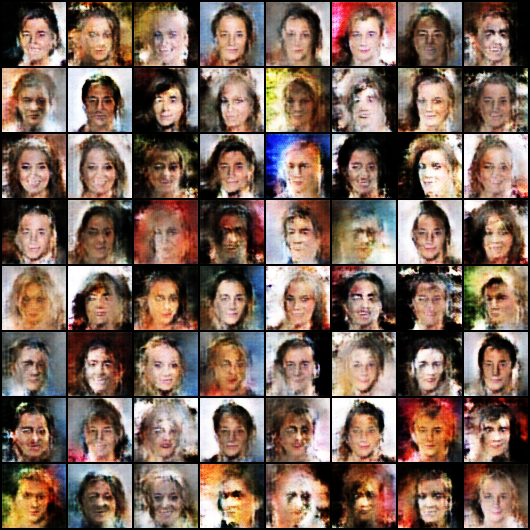

In [61]:
Image('./generated/generated-images-0200.png')

making all the output images as a video file

In [64]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 20, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

ploting the losses


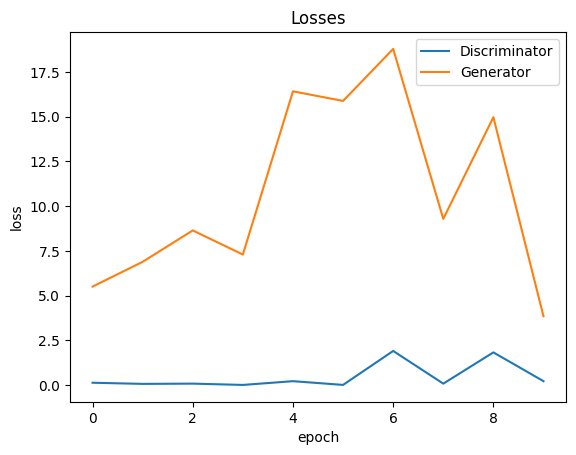

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

ploting the scores

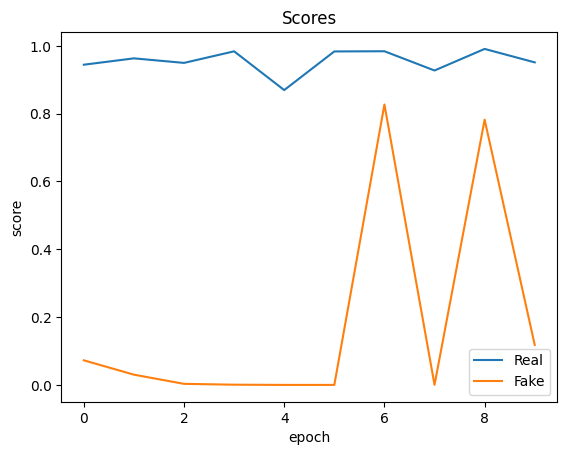

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');